In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
df = pd.read_csv("/kaggle/input/fraud-detection/fraudTrain.csv")

In [4]:
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [5]:
columns = df.columns

In [6]:
len(columns)

23

In [7]:
len(set(columns))

23

So, they are all unique, no need to drop anything for now.

In [8]:
len(df)

1296675

The dataset has more than a million records.

In [9]:
target_col = df["is_fraud"]

In [10]:
fraud = target_col[target_col == 1]

In [11]:
len(fraud)

7506

In [12]:
not_fraud = target_col[target_col == 0]

In [13]:
len(not_fraud)

1289169

In [14]:
fraud, not_fraud = np.array(fraud), np.array(not_fraud)

In [15]:
concatenated = np.concatenate((fraud, not_fraud), axis=0)

In [16]:
assert len(concatenated) == len(fraud) + len(not_fraud)

In [17]:
counts = np.bincount(concatenated)

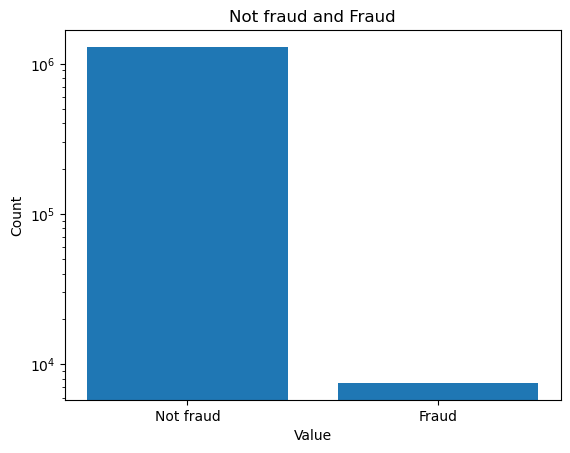

In [18]:
plt.bar([0, 1], counts)
plt.yscale('log')
plt.xlabel('Value')
plt.ylabel('Count')
plt.title('Not fraud and Fraud')

plt.xticks([0, 1], ['Not fraud', 'Fraud'])

plt.show()

As we can see, the array is highly disbalanced, due to the nature of the matter that we're dealing with.

In [19]:
df.drop("Unnamed: 0", axis=1, inplace=True)

In [20]:
df["trans_date_trans_time"][0]

'2019-01-01 00:00:18'

In [21]:
date_string = df["trans_date_trans_time"][0].split(" ")[0]
date_string

'2019-01-01'

In [22]:
date_object = datetime.strptime(date_string, "%Y-%m-%d")

In [23]:
timestamp = date_object.timestamp()

In [24]:
timestamp

1546300800.0

In [25]:
type(timestamp)

float

In [26]:
df["date"] = pd.to_datetime(df["trans_date_trans_time"])

In [27]:
df["date"] = df["date"].apply(lambda x: x.timestamp())

In [28]:
type(df["date"][0])

numpy.float64

Successfully turned the datetime to float. We could work with float.

In [29]:
df.drop("trans_date_trans_time", axis=1, inplace=True)

In [30]:
df.drop("cc_num", axis=1, inplace=True)

In [31]:
value_counts = df["merchant"].value_counts().sort_values(ascending=False)

In [32]:
value_counts = value_counts.head(10)

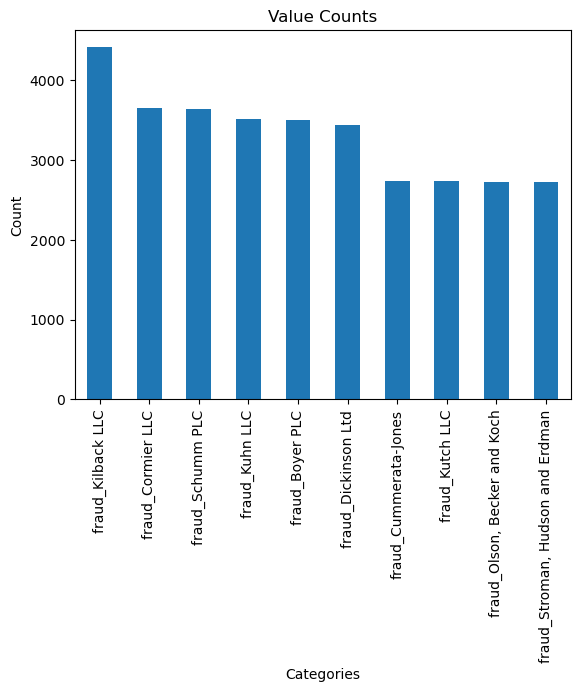

In [33]:
value_counts.plot(kind="bar")
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Value Counts')

plt.show()

These are all the data that we have, sorted.

In [34]:
merchant = df["merchant"][df["is_fraud"] == 1]

In [35]:
value_counts = merchant.value_counts().sort_values(ascending=False).head(10)

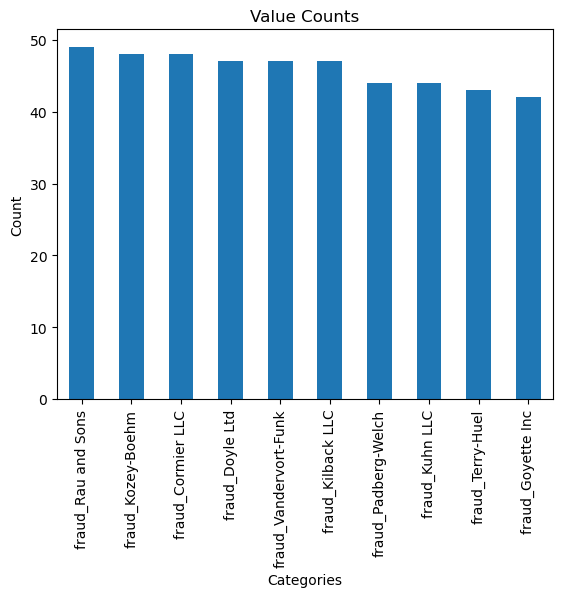

In [36]:
value_counts.plot(kind="bar")
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Value Counts')

plt.show()

These are the fraudulent merchants. These could turn out to be very important in the future, when there is a transactions coming from these, it might idicate that it's fraud.

In [37]:
category = df["category"].value_counts().sort_values(ascending=False)

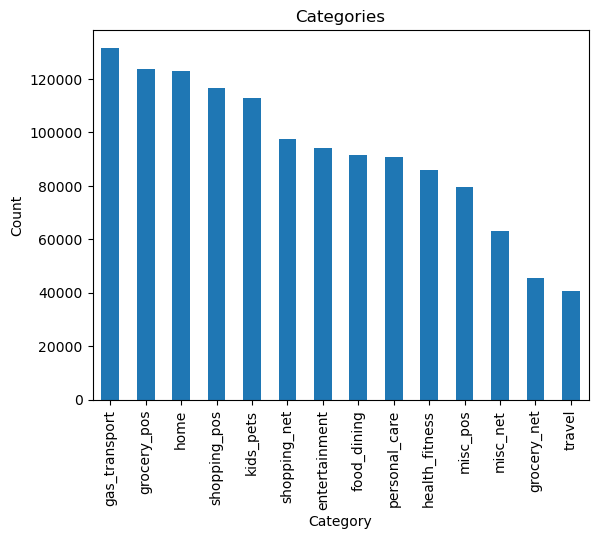

In [38]:
category.plot(kind="bar")
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Categories')

plt.show()

This is the whole category column.

In [39]:
category = df["category"][df["is_fraud"] == 1]

In [40]:
category = category.value_counts().sort_values(ascending=False)

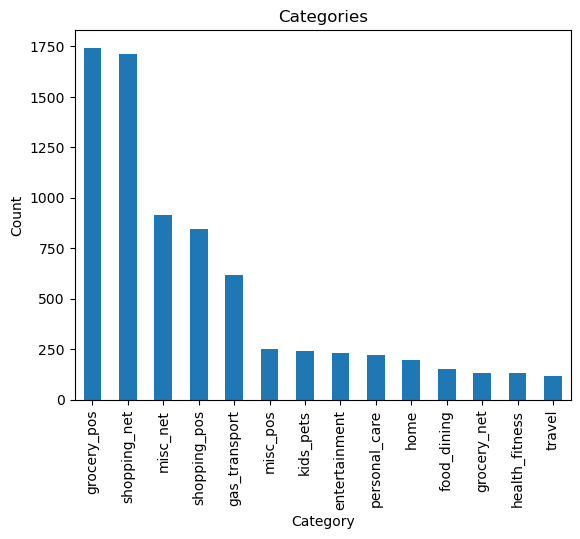

In [41]:
category.plot(kind="bar")
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Categories')

plt.show()

These are the sorted fraudulent categories.

In [42]:
amt_value_counts = df["amt"].value_counts()

In [43]:
df["amt"].describe()

count    1.296675e+06
mean     7.035104e+01
std      1.603160e+02
min      1.000000e+00
25%      9.650000e+00
50%      4.752000e+01
75%      8.314000e+01
max      2.894890e+04
Name: amt, dtype: float64

In [44]:
y_scale = list(range(len(df["amt"])))

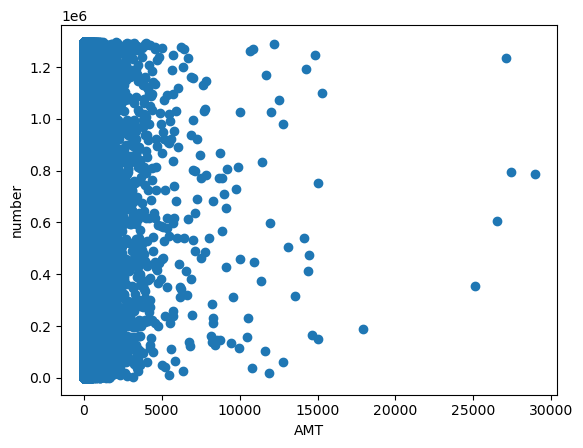

In [45]:
plt.scatter(df["amt"].values, y_scale)
plt.xlabel("AMT")
plt.ylabel("number")
plt.show()

In [46]:
fraud_names = df[df["is_fraud"] == 1][["first", "last"]]

In [47]:
fraud_names.value_counts()

first      last    
Scott      Martin      27
Jennifer   Scott       26
Robert     James       22
Susan      Garcia      20
Linda      Davis       20
                       ..
William    Perry        2
Jessica    Ward         2
Rebecca    Erickson     2
Debra      Stark        2
Katherine  Tucker       2
Length: 754, dtype: int64

In [48]:
names = fraud_names.value_counts().sort_values(ascending=False).head(10)

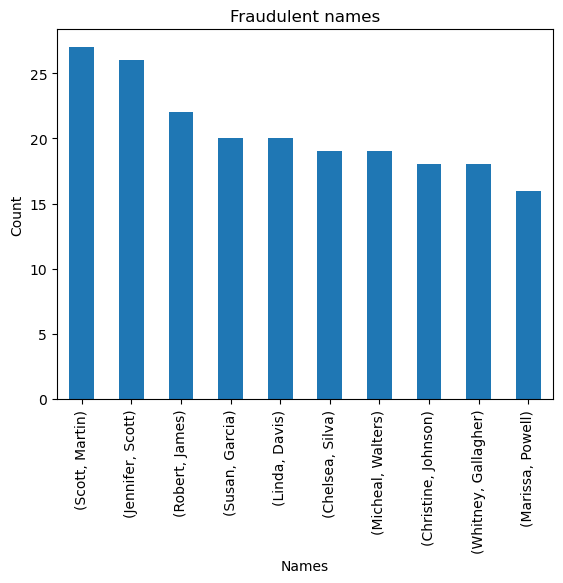

In [49]:
names.plot(kind="bar")
plt.xlabel('Names')
plt.ylabel('Count')
plt.title('Fraudulent names')

plt.show()

So the fraudsters oftenly use Scott as either first or last name.

In [50]:
gender_column = df["gender"].value_counts()

Text(0.5, 1.0, 'Gender Distribution')

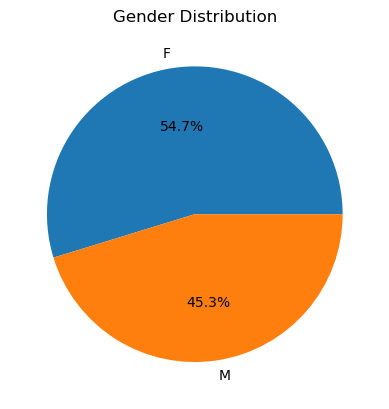

In [51]:
plt.pie(gender_column, labels=gender_column.index, autopct='%1.1f%%')
plt.title('Gender Distribution')

In [52]:
fraudulent_gender = df[df["is_fraud"] == 1]["gender"].value_counts()

Text(0.5, 1.0, 'Gender Distribution')

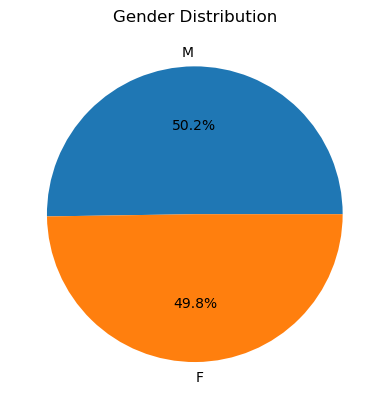

In [53]:
plt.pie(fraudulent_gender, labels=fraudulent_gender.index, autopct='%1.1f%%')
plt.title('Gender Distribution')

Well, both genders are equally fraudulent.

In [54]:
df.drop(["lat", "long", "city_pop", "dob", "trans_num", "unix_time", "merch_lat", "merch_long"], axis=1, inplace=True)

In [55]:
df.drop("street", axis=1, inplace=True)

In [56]:
df["state"].value_counts()

TX    94876
NY    83501
PA    79847
CA    56360
OH    46480
MI    46154
IL    43252
FL    42671
AL    40989
MO    38403
MN    31714
AR    31127
NC    30266
WI    29368
VA    29250
SC    29190
KY    28475
IN    27580
IA    26985
OK    26671
MD    26193
GA    26063
WV    25691
NJ    24603
NE    24168
KS    22996
MS    21188
LA    20965
WY    19322
WA    18924
OR    18597
TN    17554
ME    16505
NM    16407
ND    14786
CO    13880
MA    12376
SD    12324
VT    11768
MT    11754
AZ    10770
UT    10699
NH     8278
CT     7702
NV     5607
ID     5545
DC     3613
HI     2559
AK     2120
RI      550
DE        9
Name: state, dtype: int64

In [57]:
state_fraud = df[df["is_fraud"] == 1]["state"]

In [58]:
state_value_counts = state_fraud.value_counts().sort_values(ascending=True).head(10)

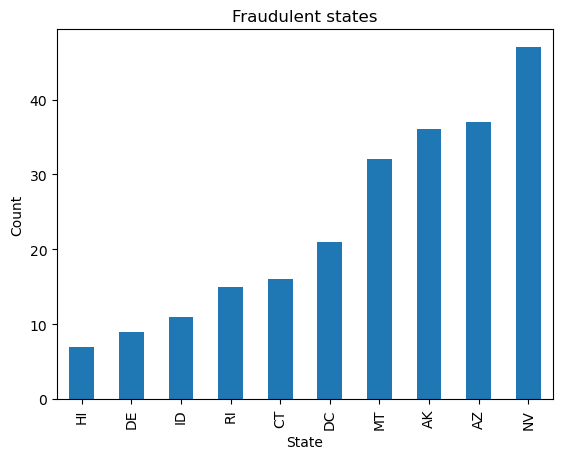

In [59]:
state_value_counts.plot(kind="bar")
plt.xlabel('State')
plt.ylabel('Count')
plt.title('Fraudulent states')

plt.show()

The first state is Nevada, maybe because Las Vegas is there, followed by Arizona.

In [60]:
df.drop("zip", axis=1, inplace=True)

In [61]:
df.columns

Index(['merchant', 'category', 'amt', 'first', 'last', 'gender', 'city',
       'state', 'job', 'is_fraud', 'date'],
      dtype='object')

In [62]:
df["job"].nunique()

494

In [63]:
fraudulent_jobs = df[df["is_fraud"] == 1]["job"].value_counts().sort_values(ascending=True).head(10)

Text(0.5, 1.0, 'Job distribution')

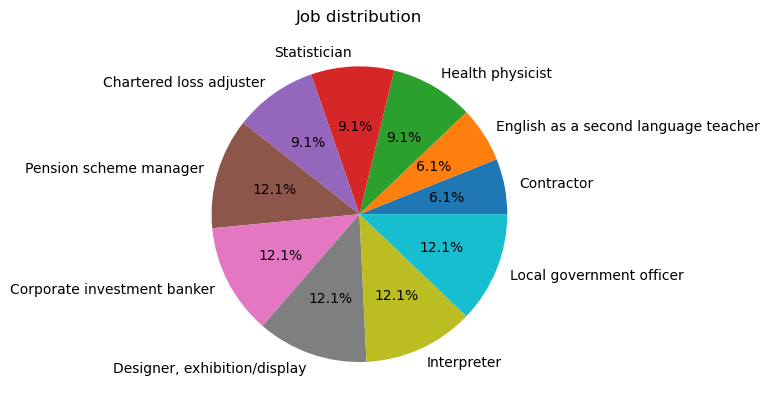

In [64]:
plt.pie(fraudulent_jobs, labels=fraudulent_jobs.index, autopct='%1.1f%%')
plt.title('Job distribution')

Well, the top most fraudulent jobs are kind of spread evenly. There are no distinguished jobs.

In [65]:
fraudulent_cities = df[df["is_fraud"] == 1]["city"].value_counts().sort_values(ascending=True).head(10)

Text(0.5, 1.0, 'Cities distribution')

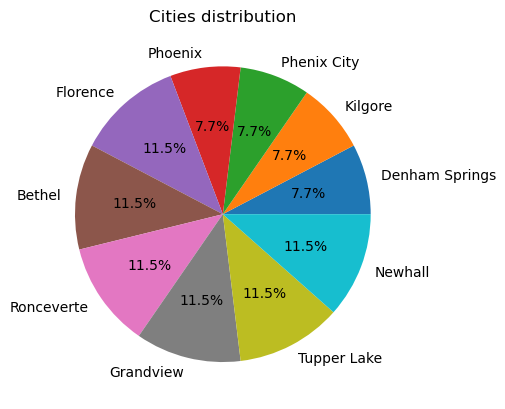

In [66]:
plt.pie(fraudulent_cities, labels=fraudulent_cities.index, autopct='%1.1f%%')
plt.title('Cities distribution')

In [67]:
df.columns

Index(['merchant', 'category', 'amt', 'first', 'last', 'gender', 'city',
       'state', 'job', 'is_fraud', 'date'],
      dtype='object')

In [68]:
enc_arr = ["abc","222","sss","fggh","33f"]

In [69]:
le = LabelEncoder()

In [70]:
result = le.fit_transform(enc_arr)

In [71]:
result

array([2, 0, 4, 3, 1])

In [72]:
for col in df.columns:
    if type(df[col][0]) == str:   
        print("The col is: ", col)
        print(df[col].nunique())
        print("-----------")

The col is:  merchant
693
-----------
The col is:  category
14
-----------
The col is:  first
352
-----------
The col is:  last
481
-----------
The col is:  gender
2
-----------
The col is:  city
894
-----------
The col is:  state
51
-----------
The col is:  job
494
-----------


In [73]:
for col in df.columns:
    if type(df[col][0]) == str:   
        df[col] = le.fit_transform(df[col])

In [74]:
min_max = MinMaxScaler()

In [75]:
df.drop("is_fraud", axis=1, inplace=True)

In [76]:
for col in df.columns:
    if type(df[col][0]) != str:
        df[col] = min_max.fit_transform(df[col].values.reshape(-1,1))

In [77]:
df["amt"]

0          0.000137
1          0.003670
2          0.007569
3          0.001520
4          0.001415
             ...   
1296670    0.000503
1296671    0.001751
1296672    0.003625
1296673    0.002553
1296674    0.000114
Name: amt, Length: 1296675, dtype: float64

In [78]:
x_train, x_test, y_train, y_test = train_test_split(df, target_col, test_size=0.2)

Everything scaled and transformed to numerical values, we're ready for some predictions. Let's start with the simplest ones and work our way up to the complex ones.

In [79]:
len(x_train)

1037340

In [80]:
assert(len(x_train) + len(x_test) == len(df))

In [81]:
linear_regression = LinearRegression()

In [82]:
linear_fit = linear_regression.fit(x_train,y_train)

In [83]:
x_train.shape, y_train.shape

((1037340, 10), (1037340,))

In [84]:
x_test.shape, y_test.shape

((259335, 10), (259335,))

In [85]:
linear_pred = linear_fit.predict(x_test)

In [86]:
y_test.shape, linear_pred.shape

((259335,), (259335,))

In [87]:
linear_pred = np.where(linear_pred >= 0.5, 1, 0)

In [88]:
max(linear_pred), min(linear_pred)

(1, 0)

In [89]:
print(classification_report(y_test, linear_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    257867
           1       0.00      0.00      0.00      1468

    accuracy                           0.99    259335
   macro avg       0.50      0.50      0.50    259335
weighted avg       0.99      0.99      0.99    259335



That's not really good. Let's try some other algorithm.

In [90]:
random_forest = RandomForestClassifier(n_estimators=50, max_depth=5)

In [91]:
random_forest_fit = random_forest.fit(x_train, y_train)

In [92]:
random_pred = random_forest_fit.predict(x_test)

In [93]:
print(classification_report(y_test, random_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    257867
           1       0.89      0.02      0.03      1468

    accuracy                           0.99    259335
   macro avg       0.94      0.51      0.52    259335
weighted avg       0.99      0.99      0.99    259335



Well, that's not exactly much better.

In [94]:
#svm = svm.SVC(kernel="linear")

In [95]:
#svm_fit = svm.fit(x_train, y_train)

In [96]:
knn = KNeighborsClassifier(n_neighbors=3)

In [97]:
knn_fit = knn.fit(x_train, y_train)

In [98]:
knn_predict = knn_fit.predict(x_test)

In [99]:
print(classification_report(y_test, knn_predict))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    257867
           1       0.33      0.08      0.13      1468

    accuracy                           0.99    259335
   macro avg       0.66      0.54      0.56    259335
weighted avg       0.99      0.99      0.99    259335



That's better than the rest of them!

In [100]:
boost_classifier = GradientBoostingClassifier(n_estimators=50)

In [101]:
boost_fit = boost_classifier.fit(x_train, y_train)

In [102]:
boost_predict = boost_fit.predict(x_test)

In [103]:
print(classification_report(y_test, boost_predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257867
           1       0.79      0.56      0.65      1468

    accuracy                           1.00    259335
   macro avg       0.89      0.78      0.83    259335
weighted avg       1.00      1.00      1.00    259335



No way, this time the algorithm is quite good. I've even turned down the estimators due to hardware limitations.

In [104]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        element = self.data.iloc[index].values
        label = self.labels.iloc[index]
        return torch.Tensor(element), label

In [105]:
custom_df = CustomDataset(x_train, y_train)

In [106]:
dataloader = DataLoader(custom_df, batch_size=32, shuffle=True)

In [107]:
class DeepClassifier(nn.Module):
    def __init__(self):
        super(DeepClassifier, self).__init__()
        
        self.sequential = nn.Sequential(
            nn.Linear(10, 512),
            nn.ReLU(),
            nn.Linear(512,512),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(512,512),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            #nn.Sigmoid()
        )
    
    def forward(self, data):
        return self.sequential(data)

In [108]:
neural_classifier = DeepClassifier()

In [109]:
n_epochs = 3
lr = 0.0001
optimizer = torch.optim.Adam(neural_classifier.parameters(), lr=lr)
loss = nn.BCEWithLogitsLoss()

In [110]:
def train():
    count = 0
    for epoch in range(n_epochs):
        for data, label in tqdm(dataloader):
            neural_classifier.train()
            
            label = label.to(torch.float32)
            label = torch.unsqueeze(label, 1)

            output = neural_classifier(data)
            
            train_loss = loss(label, output)

            optimizer.step()
            train_loss.backward()
            optimizer.zero_grad()
            
            count += 1
            if count % 5000 == 0:
                print(train_loss.item())

In [111]:
train()

 16%|█▌        | 5028/32417 [00:33<02:53, 157.69it/s]

0.6931471824645996


 31%|███       | 10017/32417 [01:05<02:18, 161.29it/s]

0.6931471824645996


 46%|████▋     | 15020/32417 [01:37<01:47, 162.45it/s]

0.6931471824645996


 62%|██████▏   | 20016/32417 [02:08<01:16, 161.75it/s]

0.6931471824645996


 77%|███████▋  | 25025/32417 [02:40<00:45, 162.89it/s]

0.6931471824645996


 93%|█████████▎| 30025/32417 [03:12<00:15, 151.57it/s]

0.6931471824645996


  8%|▊         | 2607/32417 [00:16<03:05, 160.34it/s]

0.6931471824645996


 23%|██▎       | 7604/32417 [00:49<02:34, 160.62it/s]

0.6931471824645996


 39%|███▉      | 12603/32417 [01:22<02:27, 134.71it/s]

0.6931471824645996


 54%|█████▍    | 17611/32417 [01:53<01:33, 158.41it/s]

0.6931471824645996


 70%|██████▉   | 22613/32417 [02:26<00:59, 163.74it/s]

0.6931471824645996


 85%|████████▌ | 27603/32417 [02:57<00:30, 160.45it/s]

0.6931471824645996


  1%|          | 192/32417 [00:01<03:31, 152.47it/s]

0.6931471824645996


 16%|█▌        | 5182/32417 [00:33<02:53, 156.81it/s]

0.6931471824645996


 31%|███▏      | 10195/32417 [01:06<02:25, 152.31it/s]

0.6931471824645996


 47%|████▋     | 15182/32417 [01:39<01:50, 156.47it/s]

0.6931471824645996


 62%|██████▏   | 20185/32417 [02:12<01:16, 160.89it/s]

0.6931471824645996


 78%|███████▊  | 25180/32417 [02:45<00:55, 130.86it/s]

0.6931471824645996


 93%|█████████▎| 30198/32417 [03:18<00:13, 159.81it/s]

0.6931471824645996


100%|██████████| 32417/32417 [03:33<00:00, 151.98it/s]


In [112]:
len(x_test), len(y_test)

(259335, 259335)

In [113]:
custom_test = CustomDataset(x_test, y_test)

In [114]:
test_dataloader = DataLoader(custom_test, batch_size=8, shuffle=True)

In [115]:
neural_classifier.eval()
true_labels = []
predicted_labels = []

for batch in dataloader:
    inputs, labels = batch
    outputs = neural_classifier(inputs)

    _, predicted = torch.max(outputs, dim=1)

    true_labels.extend(labels.tolist())
    predicted_labels.extend(predicted.tolist())

In [116]:
print(classification_report(true_labels, predicted_labels))

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.99      1.00      1.00   1031302
           1       0.00      0.00      0.00      6038

    accuracy                           0.99   1037340
   macro avg       0.50      0.50      0.50   1037340
weighted avg       0.99      0.99      0.99   1037340



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Nothing really different than the other algorithms, except boosting algorithm.